In [1]:
%pylab inline
hubble_data = np.array([[  2.78000000e+02,   6.50000000e+02,   1.52000000e+00],
       [  5.84000000e+02,   1.80000000e+03,   3.45000000e+00],
       [  9.36000000e+02,   1.30000000e+03,   2.37000000e+00],
       [  1.02300000e+03,   3.00000000e+02,   6.20000000e-01],
       [  1.70000000e+03,   8.00000000e+02,   1.16000000e+00],
       [  2.68100000e+03,   7.00000000e+02,   1.42000000e+00],
       [  2.68300000e+03,   4.00000000e+02,   6.70000000e-01],
       [  2.84100000e+03,   6.00000000e+02,   1.24000000e+00],
       [  3.03400000e+03,   2.90000000e+02,   7.90000000e-01],
       [  3.11500000e+03,   6.00000000e+02,   1.00000000e+00],
       [  3.36800000e+03,   9.40000000e+02,   1.74000000e+00],
       [  3.37900000e+03,   8.10000000e+02,   1.49000000e+00],
       [  3.48900000e+03,   6.00000000e+02,   1.10000000e+00],
       [  3.52100000e+03,   7.30000000e+02,   1.27000000e+00],
       [  3.62300000e+03,   8.00000000e+02,   1.53000000e+00],
       [  4.11100000e+03,   8.00000000e+02,   1.79000000e+00],
       [  4.52600000e+03,   5.80000000e+02,   1.20000000e+00],
       [  4.56500000e+03,   1.10000000e+03,   2.35000000e+00],
       [  4.59400000e+03,   1.14000000e+03,   2.23000000e+00],
       [  5.00500000e+03,   9.00000000e+02,   2.06000000e+00],
       [  5.86600000e+03,   6.50000000e+02,   1.73000000e+00]])

Populating the interactive namespace from numpy and matplotlib


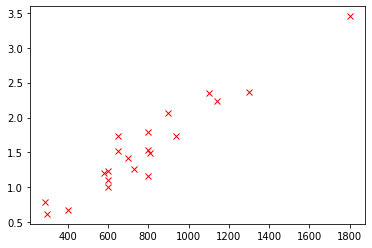

In [2]:
plt.plot(hubble_data[:,1],hubble_data[:,2],"rx")

In [22]:
def chisquared(x_dat,x_model, sigma = 0.5):
    return np.sum((x_dat  - x_model)**2/sigma)

In [23]:
m_values = np.linspace(100,2000,2000) # free parameter
chi_squared = np.zeros(m_values.shape)
for i,j in enumerate(m_values):
    chi_squared[i] = chisquared(hubble_data[:,2],1/j*hubble_data[:,1])

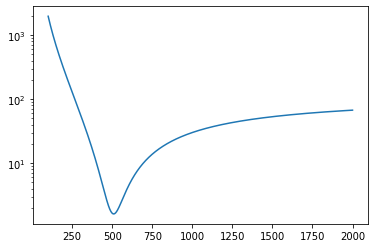

In [24]:
plt.semilogy(m_values,chi_squared)

In [25]:
dof = len(hubble_data[:,2]) + 1 

In [26]:
dof

22

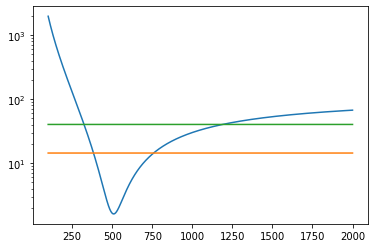

In [29]:
level_10 = 14.4
level_1 = 40.3

plt.semilogy(m_values,chi_squared)
plt.semilogy(m_values,np.ones(m_values.shape)*level_10)
plt.semilogy(m_values,np.ones(m_values.shape)*level_1)

(array([1.000e+00, 0.000e+00, 1.000e+00, 2.000e+00, 3.100e+01, 7.300e+01,
        2.090e+02, 4.500e+02, 7.300e+02, 1.241e+03, 1.581e+03, 1.690e+03,
        1.533e+03, 1.090e+03, 7.110e+02, 3.900e+02, 1.740e+02, 6.900e+01,
        1.900e+01, 5.000e+00]),
 array([-4.28066266, -3.02723187, -1.77380107, -0.52037028,  0.73306052,
         1.98649131,  3.23992211,  4.4933529 ,  5.7467837 ,  7.00021449,
         8.25364529,  9.50707608, 10.76050687, 12.01393767, 13.26736846,
        14.52079926, 15.77423005, 17.02766085, 18.28109164, 19.53452244,
        20.78795323]),
 <a list of 20 Patch objects>)

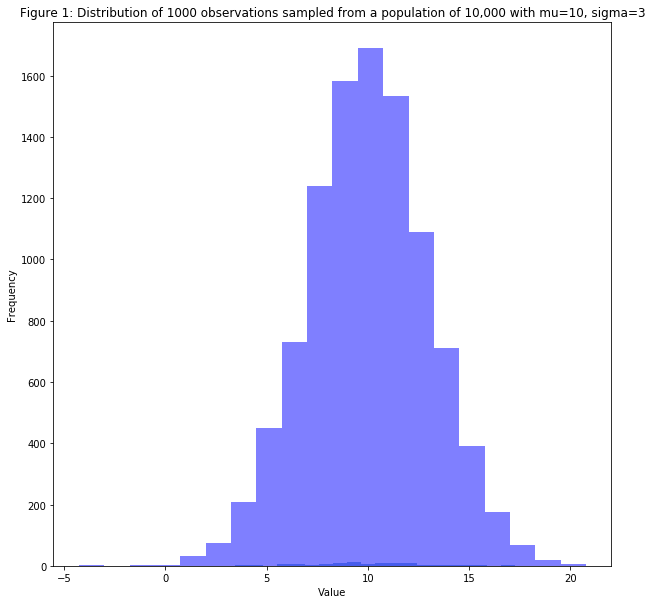

In [66]:
#model =lambda t:np.random.normal(10,3,t) # a gaussian distribution with norm average 10, stdev 3

def model(t):
    return np.random.normal(10,3,t)

population = model(10000) #draw 100000 samples

#Assume we are only able to observe 1,000 of these individuals. 
observation = population[np.random.randint(0, 10000, 100)]

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
ax.hist( observation,bins=20,alpha = 0.5)
ax.set_xlabel("Value")
ax.set_ylabel("Frequency")
ax.set_title("Figure 1: Distribution of 1000 observations sampled from a population of 10,000 with mu=10, sigma=3")
mu_obs=observation.mean()

ax.hist(population,bins=20, alpha = 0.5,color = "blue")




In [67]:
transition_model = lambda x: [x[0],np.random.normal(x[1],0.5,(1,))] #how big of jumps we are making 

def prior(x):
    #x[0] = mu, x[1]=sigma (new or current)
    #returns 1 for all valid values of sigma. Log(1) =0, so it does not affect the summation.
    #returns 0 for all invalid values of sigma (<=0). Log(0)=-infinity, and Log(negative number) is undefined.
    #It makes the new sigma infinitely unlikely.
    if(x[1] <=0):
        return 0
    return 1

#Computes the likelihood of the data given a sigma (new or current) according to equation (2)
def manual_log_like_normal(x,data):
    #x[0]=mu, x[1]=sigma (new or current)
    #data = the observation
    return np.sum(-np.log(x[1] * np.sqrt(2* np.pi) )-((data-x[0])**2) / (2*x[1]**2))

#Same as manual_log_like_normal(x,data), but using scipy implementation. It's pretty slow.


#Defines whether to accept or reject the new sample
def acceptance(x, x_new):
    if x_new>x:
        return True
    else:
        accept=np.random.uniform(0,1)
        # Since we did a log likelihood, we need to exponentiate in order to compare to the random number
        # less likely x_new are less likely to be accepted
        return (accept < (np.exp(x_new-x)))


def metropolis_hastings(likelihood_computer,prior, transition_model, param_init,iterations,data,acceptance_rule):
    # likelihood_computer(x,data): returns the likelihood that these parameters generated the data
    # transition_model(x): a function that draws a sample from a symmetric distribution and returns it
    # param_init: a starting sample
    # iterations: number of accepted to generated
    # data: the data that we wish to model
    # acceptance_rule(x,x_new): decides whether to accept or reject the new sample
    x = param_init
    accepted = []
    rejected = []   
    for i in range(iterations):
        x_new =  transition_model(x) 
        x_lik = likelihood_computer(x,data)
        x_new_lik = likelihood_computer(x_new,data) 
        if (acceptance(x_lik + np.log(prior(x)),x_new_lik+np.log(prior(x_new)))):            
            x = x_new
            accepted.append(x_new)
        else:
            rejected.append(x_new)            
                
    return np.array(accepted), np.array(rejected)

In [68]:
accepted, rejected = metropolis_hastings(manual_log_like_normal,prior,transition_model,[mu_obs,0.1], 50000,observation,acceptance)


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in log
  app.launch_new_instance()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in log


In [69]:
stdev = np.array([i for i in accepted[:,1]])

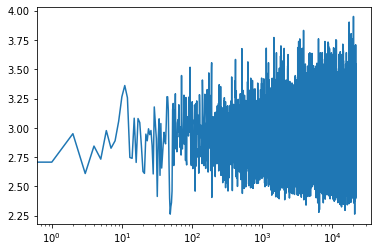

In [70]:
plt.semilogx(stdev[100:])

In [71]:
#plt.hist(stdev[100:])
mean = stdev[100:].mean()
std = np.std(stdev[100:])

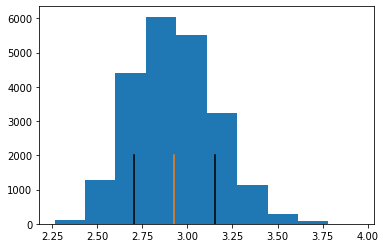

In [72]:
plt.hist(stdev[100:])
plt.plot([mean,mean],[0,2000])
plt.plot([mean+std,mean+std],[0,2000],"k")
plt.plot([mean-std,mean-std],[0,2000],"k")

In [73]:
import emcee

In [75]:
def lnprob(x,mu):
    diff = x - mu
    return - np.dot(diff,diff)/2.0

In [76]:
nwalkers = 250 #guessing!
ndim = 3

In [78]:
p0 = np.random.rand(ndim*nwalkers).reshape((nwalkers,ndim))

In [81]:
means = np.random.rand(ndim) #target distribution

In [83]:
sampler = emcee.EnsembleSampler(nwalkers,ndim,lnprob,args=[means])

In [88]:
pos, prob, state = sampler.run_mcmc(p0,100) #burnin 
sampler.reset()

In [91]:
_ = sampler.run_mcmc(pos,1000)

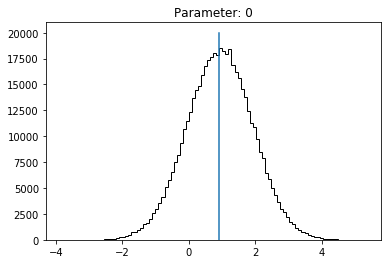

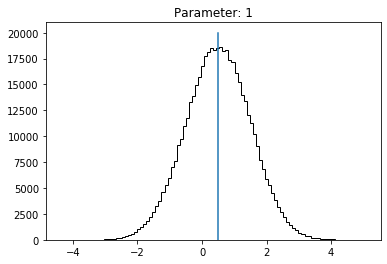

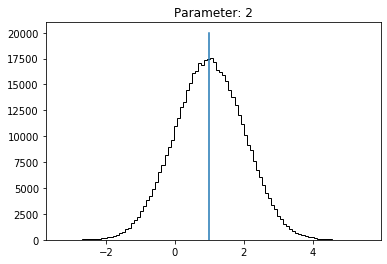

In [97]:
for i in range(3):
    plt.figure()
    plt.hist(sampler.flatchain[:,i],100,color="k",histtype="step")
    plt.plot([means[i],means[i]],[0,20000])
    plt.title("Parameter: "+ str(i))
    plt.show()

In [98]:
import corner

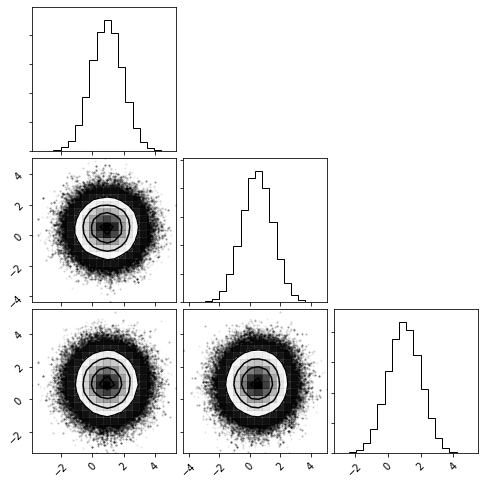

In [99]:
figure = corner.corner(sampler.flatchain[:])

In [100]:
ndim = 3

In [119]:
cov = 0.5 - np.random.rand(ndim**2).reshape((ndim,ndim))

In [128]:
cov = np.triu(cov)
print(cov)

[[-0.12806173 -0.25332577 -0.2230994 ]
 [ 0.         -0.02629275 -0.48734262]
 [ 0.          0.          0.05425494]]


In [129]:
cov += cov.T - np.diag(cov.diagonal())
cov = np.dot(cov,cov) #symmetrizing the matrix!

In [130]:
icov = np.linalg.inv(cov) #matrix inversion

In [131]:
icov

array([[120.8630454 , -51.91264043, -50.5994738 ],
       [-51.91264043,  25.67536135,  21.23407747],
       [-50.5994738 ,  21.23407747,  24.70297742]])

In [132]:
def lnprob(x,mu,icov):
    diff = x - mu
    return - np.dot(diff,np.dot(icov,diff))/2.0


In [133]:
sampler = emcee.EnsembleSampler(nwalkers,ndim,lnprob,args=[means,icov])

In [134]:
pos, prob, state = sampler.run_mcmc(p0,100) #burnin 
sampler.reset()

In [135]:
_ = sampler.run_mcmc(pos,1000)

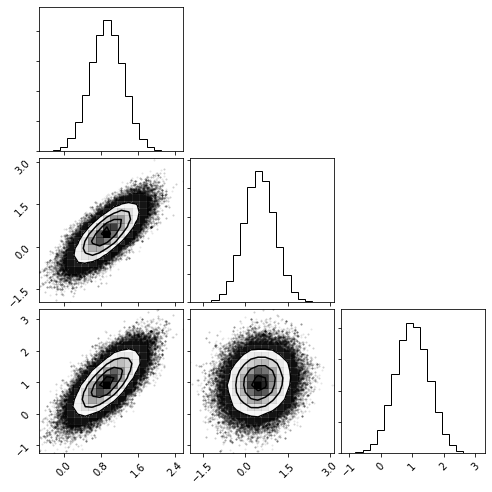

In [136]:
figure = corner.corner(sampler.flatchain[:])